In [1]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.color import rgb2lab, lab2rgb
from tqdm import tqdm

from utils import build_fragment_from_directory, Fragment
from shape_align import align_two_fragments, pairwise_alignment
from shape_utils import get_colorized_edge
from shape_utils import linearize_edge
from curvature import edge_coords2curvatures
from shape_align import water
from typing import List, Dict, Tuple
from joblib import Parallel, delayed

In [2]:
data_dir = '../dataset'
palette = np.array([[4.83058360e+01, -4.28336049e+00, -1.04226657e+00],
                    [7.28763389e+01,  1.10190913e+01,  2.91083397e+01],
                    [1.93975643e+01,  8.21757008e+00, -6.52862709e+00],
                    [6.12470461e+01,  6.38868771e+00,  1.05191202e+01],
                    [8.70237508e+01,  2.60029629e+00,  6.34060233e+00],
                    [3.84328672e+01,  2.22768163e+01,  1.17465682e+00],
                    [3.29131583e+01,  3.06846260e-02, -6.19825618e+00]])

In [3]:
frag1 = build_fragment_from_directory(data_dir + '/9')
frag2 = build_fragment_from_directory(data_dir + '/11')

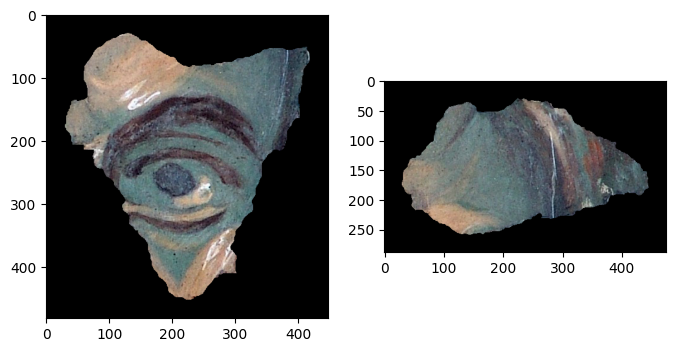

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8,6))
axes[0].imshow(frag1.fragment)
axes[1].imshow(frag2.fragment)

In [5]:
# def align_two_fragments(
#     palette, 
#     frag1, frag2, 
#     to_print=None, 
#     shape_descriptor1=None, 
#     shape_descriptor2=None
# ):
#     if to_print is not None:
#         print(to_print)
#     if shape_descriptor1 is None:
#         shape_descriptor1 = fragment2shape_descriptor(palette, frag1)
#     color_edge1 , curvs1 = shape_descriptor1.color_edge, shape_descriptor1.curvatures
        
#     if shape_descriptor2 is None:
#         shape_descriptor2 = fragment2shape_descriptor(palette, frag2)
#     color_edge2 , curvs2 = shape_descriptor2.color_edge, shape_descriptor2.curvatures

#     return water(color_edge1, color_edge2[::-1], None, None, curvs1, curvs2[::-1])

In [6]:
# class ShapeDescriptor:
#     def __init__(self, color_edge, edge_coords, curvatures):
#         self.color_edge = color_edge
#         self.edge_coords = edge_coords
#         self.curvatures = curvatures
        
    

In [7]:
# def fragment2shape_descriptor(palette, frag: Fragment) -> ShapeDescriptor:
#     """Compute shape descriptors for fragment."""
#     return ShapeDescriptor(
#         get_colorized_edge(palette, frag)[0],
#         linearize_edge(frag.mask),
#         edge_coords2curvatures(linearize_edge(frag.mask))
#     )

In [8]:
# def fragments2shape_descriptors(palette, fragments: List) -> List[ShapeDescriptor]:
#     """Compute shape descriptors for fragments.

#     Args:
#         fragments: List of fragments.
#     """
#     return Parallel(n_jobs=-1)([delayed(fragment2shape_descriptor)(palette, f) for f in fragments])

In [9]:
# def pairwise_alignment(palette, fragments: List) -> Tuple[List[ShapeDescriptor], Dict[Tuple[int, int], np.ndarray]]:
#     """Compute pairwise alignment between fragments.

#     Args:
#         fragments: List of fragments.
#     """
#     print("Computing shape descriptors...")
#     shape_descriptors = fragments2shape_descriptors(palette, fragments)
#     print("Computing pairwise alignments...")
#     alignment_dict =        {
#             (i, j): align_two_fragments(
#                 palette,
#                 frag1, frag2, 
#                 to_print=f"Aligning fragments {i} and {j}:", 
#                 shape_descriptor1=shape_descriptors[i], 
#                 shape_descriptor2=shape_descriptors[j]
#             )[0]
#             for i, frag1 in enumerate(fragments)
#             for j, frag2 in enumerate(fragments)
#             if j > i
#         }
        
    
#     return shape_descriptors, alignment_dict

In [10]:
frags = [
    build_fragment_from_directory(data_dir + '/9'),
    build_fragment_from_directory(data_dir + '/11')
#     build_fragment(95, None), 
#     build_fragment(103, None), 
#     build_fragment(14, None), 
#     build_fragment(15, None),
#     build_fragment(10, None),
]

In [11]:
descriptors, alignment = pairwise_alignment(palette,frags)

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|██████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:11<00:00, 225.95it/s]


In [12]:
def backtrace(
    pointer,
    score,
    seq1, seq2,
    block_i, block_j, 
    block_size_y, block_size_x
):
    roi = score[block_i * block_size_y : (block_i + 1) * block_size_y, block_j * block_size_x : (block_j + 1) * block_size_x]
    argmax = np.argmax(roi)
    max_i, max_j = np.unravel_index(argmax, roi.shape)
    max_i, max_j = max_i + block_i * block_size_y, max_j + block_j * block_size_x
#     print(roi.shape, roi.max(), argmax, max_i, max_j)
    
    indices = []
    i, j = max_i, max_j
    while pointer[i][j] > 0:
        indices.append((i, j))
        if pointer[i][j] == 3:
            i -= 1
            j -= 1
        elif pointer[i][j] == 2:
            j -= 1
        elif pointer[i][j] == 1:
            i -= 1
    return np.array(indices)

In [22]:
# from shape_align import aligned_coords2line
from find_transform import aligned_coords2line, find_best_transform_ransac, transform_line
import random
from shape_utils import ShapeDescriptor
from shape_align import fragments2shape_descriptors
from joblib import Parallel, delayed

In [14]:
def estimate_max_squared_transformation_error(line1, line2, trasform_params):
    """
    line1, line2 - np.arrays, shape (n, 2)
    transforms_params - tuple (cos, sin, a, b) of transform parameters line1 -> line2
    returns mean squared error
    """
    transformed_line1 = transform_line(line1, trasform_params)
    return np.linalg.norm(line2 - transformed_line1, axis=1).max()

In [15]:
class Alignment:
    def __init__(self, indices, conf):
        self.indices = indices
        self.conf = conf
        
        
        
    

In [16]:
def iou(indices1, indices2):
    set1 = set([tuple(p) for p in indices1])
    set2 = set([tuple(p) for p in indices2])
    iou = len(set1.intersection(set2)) / len(set1.union(set2))
    return iou

def alignment_nms(aligns, edge_coords1, edge_coords2):
    aligns.sort(key=lambda x: x.conf, reverse=False)
    align_coords1 = [aligned_coords2line(aligns[i].indices, edge_coords1, left=True) for i in range(len(aligns))]
    align_coords2 = [aligned_coords2line(aligns[i].indices, edge_coords2[::-1], left=False) for i in range(len(aligns))]
    i = 0
    while i < len(aligns):
        j = i + 1
        while j < len(aligns):
            iou_score = (iou(align_coords1[i], align_coords1[j]) + iou(align_coords2[i], align_coords2[j])) / 2
            
#             print(i, '-', j, ':', iou_score)
            if iou_score > 0.5:
                aligns.pop(j)
            else:
                j += 1
        i += 1
    return aligns

def generate_multiple_alignments(pointer, score, dsc1, dsc2, blocks_num):
    block_size_y = int(pointer.shape[0] / blocks_num)
    block_size_x = int(pointer.shape[1] / blocks_num)
    color_edge1 = dsc1.color_edge
    color_edge2 = dsc2.color_edge
    edge_coords1 = dsc1.edge_coords
    edge_coords2 = dsc2.edge_coords

    best_indices = None
    best_mse = 10000
    aligns = []
    for i in range(blocks_num):
        for j in range(blocks_num):
            indices = backtrace(pointer, score, color_edge1, color_edge2[::-1], i, j, block_size_y, block_size_x)
            if len(indices) < 50:
                continue
            line1 = aligned_coords2line(indices, edge_coords1, left=True)
            line2 = aligned_coords2line(indices, edge_coords2[::-1], left=False)
            best_transform = find_best_transform_ransac(line1, line2)
            if best_transform is None:
                continue
            mse = estimate_max_squared_transformation_error(line1, line2, best_transform)
            aligns.append(Alignment(indices, mse))
    print(len(aligns))
    aligns = alignment_nms(aligns, edge_coords1, edge_coords2)
    print(len(aligns))
    return aligns

In [20]:
def new_pairwise_alignment(palette, fragments: List, blocks_num=5) -> Tuple[List[ShapeDescriptor], Dict[Tuple[int, int], np.ndarray]]:
    """Compute pairwise alignment between fragments.

    Args:
        fragments: List of fragments.
    """
    print("Computing shape descriptors...")
    shape_descriptors = fragments2shape_descriptors(palette, fragments)
    print("Computing pairwise alignments...")
    alignment_dict = {}
    for i, frag1 in enumerate(fragments):
        for j, frag2 in enumerate(fragments):
            if j > i:
                indices, pointer, score = align_two_fragments(
                    palette,
                    frag1, frag2, 
                    to_print=f"Aligning fragments {i} and {j}:", 
                    shape_descriptor1=shape_descriptors[i], 
                    shape_descriptor2=shape_descriptors[j]
                )
                aligns = generate_multiple_alignments(pointer, score, shape_descriptors[i], shape_descriptors[j], blocks_num)
                alignment_dict[(i, j)] = aligns
    
    return shape_descriptors, alignment_dict

In [23]:
descriptors, alignment = new_pairwise_alignment(palette,frags)

Computing shape descriptors...
Computing pairwise alignments...
Aligning fragments 0 and 1:


100%|██████████████████████████████████████████████████████████████████████████████| 2516/2516 [00:11<00:00, 221.20it/s]


25
1


In [24]:
aligns = alignment[(0, 1)]

In [25]:
aligns.sort(key=lambda x: x.conf, reverse=False)
aligns[0].conf

3.146200902946905

In [26]:
i = 0

In [27]:
best_indices = aligns
# print(aligns[i].conf)
indices = best_indices

In [28]:
best_indices = aligns[i].indices
print(aligns[i].conf)
indices = best_indices

3.146200902946905


In [30]:
l, r = 0, 1
align_i = 0

In [31]:
import skimage
from skimage.color import rgb2hsv, hsv2rgb

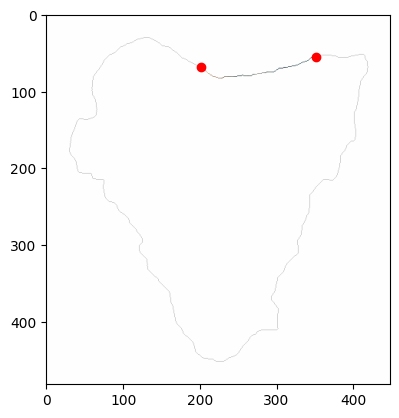

In [32]:
common_edge = np.ones(frags[l].fragment.shape)
color_edge, edge_coords, curvs = descriptors[l].color_edge, descriptors[l].edge_coords, descriptors[l].curvatures
# indices = alignment[(l, r)][align_i].indices
i_indices = [i for (i, j) in indices]
for i, point in enumerate(edge_coords):
    common_edge[point[0], point[1]] = 0.8
t = 50
if 20 <= t <= 30:
    alpha = (t - 20) / 10
    discount = 1.25 * (1 - alpha) + 1 * alpha
    common_edge = skimage.color.rgb2hsv(common_edge)
    common_edge[:,:,2] /= discount
#     common_edge /= 1.5
    common_edge = skimage.color.hsv2rgb(common_edge)
common_edge = rgb2lab(common_edge)
    
gold = rgb2lab(np.array([255,215,0])[None,None,:] / 255)[0,0]
half_gold = rgb2hsv(np.array([255,215,0])[None,None,:] / 255) 
half_gold[:,:,1] /= 3
half_gold = rgb2lab(hsv2rgb(half_gold))[0,0]
gray = rgb2lab(np.array([0.8, 0.8, 0.8])[None,None,:])
for (i, j) in indices:
    color = color_edge[i - 1]
    if t < 20:
        color = gray
    elif t < 40:
        alpha = (t - 20) / 20
        color = alpha * color_edge[i - 1] + (1 - alpha) * gold
        
        
    y, x = edge_coords[i - 1]
    common_edge[y, x] = color
    if 20 <= t < 40:
        common_edge[y, x + 1] = half_gold
        common_edge[y, x - 1] = half_gold
        common_edge[y + 1, x] = half_gold
        common_edge[y - 1, x] = half_gold

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][0] - 1]
y2, x2 = edge_coords[indices[-1][0] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

In [33]:
def create_left_vis(t):
    common_edge = np.ones(frags[l].fragment.shape)
    color_edge, edge_coords, curvs = descriptors[l].color_edge, descriptors[l].edge_coords, descriptors[l].curvatures
    indices = alignment[(l, r)][align_i].indices
    i_indices = [i for (i, j) in indices]
    for i, point in enumerate(edge_coords):
        common_edge[point[0], point[1]] = 0.8
    if 20 <= t <= 30:
        alpha = (t - 20) / 10
        discount = 1.25 * (1 - alpha) + 1 * alpha
        common_edge = skimage.color.rgb2hsv(common_edge)
        common_edge[:,:,2] /= discount
    #     common_edge /= 1.5
        common_edge = skimage.color.hsv2rgb(common_edge)
    common_edge = rgb2lab(common_edge)

    gold = rgb2lab(np.array([255,215,0])[None,None,:] / 255)[0,0]
    gray = rgb2lab(np.array([0.8, 0.8, 0.8])[None,None,:])
    for (i, j) in indices:
        color = color_edge[i - 1]
        y, x = edge_coords[i - 1]
#         if t < 20:
#             color = gray
#         elif t < 40:
#             alpha = (t - 20) / 20
#             color = alpha * color + (1 - alpha) * gold


        if 20 <= t < 30:
            half_gold = rgb2hsv(np.array([255,215,0])[None,None,:] / 255) 
            coef = (31 - t) / 10
            half_gold[:,:,1] /= (3 / coef)
            half_gold = rgb2lab(hsv2rgb(half_gold))[0,0]
            common_edge[y, x + 1] = half_gold
            common_edge[y, x - 1] = half_gold
            common_edge[y + 1, x] = half_gold
            common_edge[y - 1, x] = half_gold
    
    for (i, j) in indices:
        color = color_edge[i - 1]
        if t < 20:
            color = gray
        elif t < 40:
            alpha = (t - 20) / 20
            color = alpha * color + (1 - alpha) * gold

        y, x = edge_coords[i - 1]
        common_edge[y, x] = color
            
    common_edge = lab2rgb(common_edge)
    if t >= 20:
        y1, x1 = edge_coords[indices[0][0] - 1]
        y2, x2 = edge_coords[indices[-1][0] - 1]
        rr, cc = skimage.draw.disk((y1, x1), 5)
        common_edge[rr, cc] = np.array([1, 0, 0])
        rr, cc = skimage.draw.disk((y2, x2), 5)
        common_edge[rr, cc] = np.array([1, 0, 0])
        
            
    return common_edge

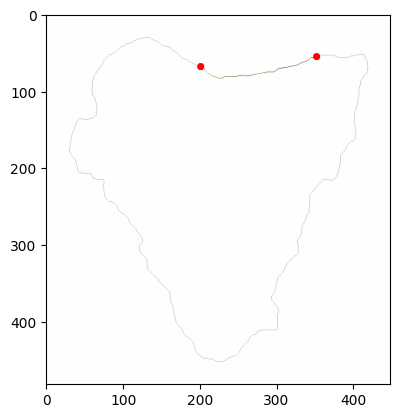

In [34]:
vis = create_left_vis(35)
plt.imshow(vis)

In [35]:
import cv2

In [36]:
def create_video_from_images():
    video_filename = 'output/created_video.mp4'

    first_image = create_left_vis(0)
    h, w, _ = first_image.shape

    codec = cv2.VideoWriter_fourcc(*'mp4v')
    vid_writer = cv2.VideoWriter(video_filename, codec, 30, (w, h))

    for t in range(50):
#         loaded_img = cv2.imread(os.path.join(folder, img))
        loaded_img = (255 * create_left_vis(t)).astype(np.uint8)
        loaded_img = cv2.cvtColor(loaded_img, cv2.COLOR_RGB2BGR)
        for _ in range(5):
            vid_writer.write(loaded_img)

    vid_writer.release()

In [37]:

# Create video from resized images
create_video_from_images()

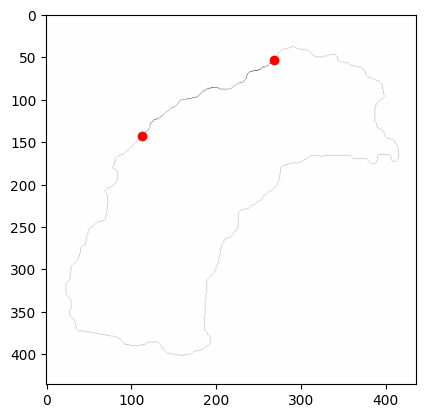

In [20]:
common_edge = np.ones(frags[r].fragment.shape)
color_edge, edge_coords, curvs = descriptors[r].color_edge[::-1], descriptors[r].edge_coords[::-1], descriptors[r].curvatures[::-1]
# indices = alignment[(l, r)][align_i].indices
i_indices = [j for (i, j) in indices]
for i, point in enumerate(edge_coords):
    common_edge[point[0], point[1]] = 0.8
common_edge = rgb2lab(common_edge)
    
for (i, j) in indices:
    color = color_edge[j - 1]
    y, x = edge_coords[j - 1]
    common_edge[y, x] = color

plt.imshow(lab2rgb(common_edge))
common_edge = lab2rgb(common_edge)
y1, x1 = edge_coords[indices[0][1] - 1]
y2, x2 = edge_coords[indices[-1][1] - 1]
plt.scatter([x1, x2], [y1, y2], color='r')
plt.imshow(common_edge)

In [58]:
def generate_vis_at_moment()

SyntaxError: expected ':' (1137801912.py, line 1)

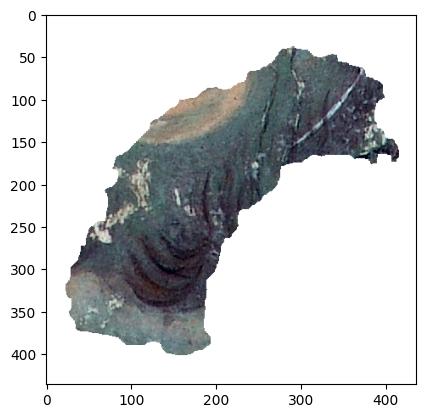

In [27]:
fr = frag2.fragment
fr[frag2.mask[:,:,0] == False] = 1
plt.imshow(fr)